In [1]:
!pip install wfdb scipy matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 68.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


Signal length: 650000 samples
Sampling frequency: 360 Hz


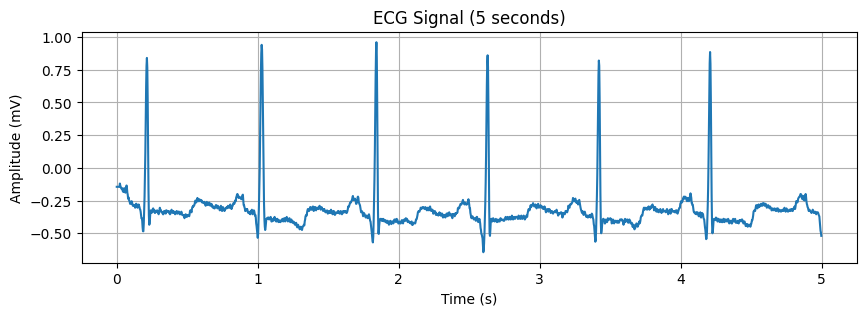

In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt


record = wfdb.rdrecord('100', pn_dir='mitdb')
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')


ecg = record.p_signal[:,0]
fs = record.fs
print("Signal length:", len(ecg), "samples")
print("Sampling frequency:", fs, "Hz")


t = np.arange(0, 5, 1/fs)
plt.figure(figsize=(10,3))
plt.plot(t, ecg[:int(5*fs)])
plt.title("ECG Signal (5 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid()
plt.show()


In [3]:
from scipy.signal import decimate

ecg_down = decimate(ecg, 2)
fs_down = fs / 2


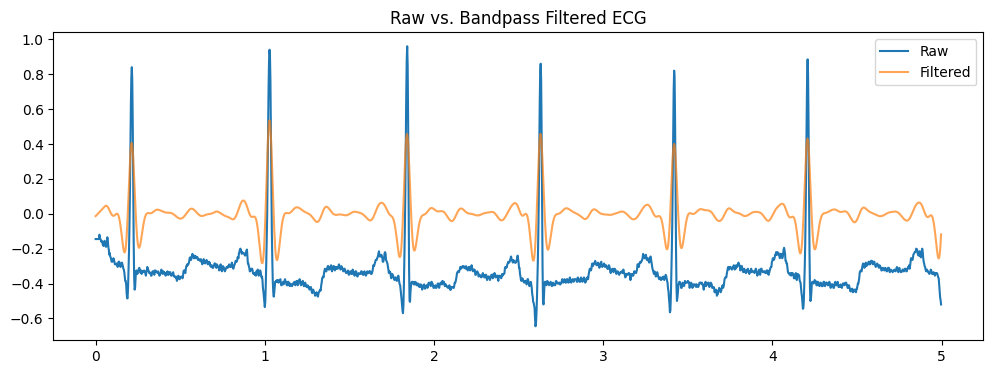

In [4]:
from scipy.signal import butter, filtfilt

def bandpass_filter(sig, lowcut=5, highcut=15, fs=360, order=2):
    nyquist = 0.5 * fs
    b, a = butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')
    y = filtfilt(b, a, sig)
    return y

filtered_ecg = bandpass_filter(ecg, fs=fs)

plt.figure(figsize=(12,4))
plt.plot(t, ecg[:int(5*fs)], label='Raw')
plt.plot(t, filtered_ecg[:int(5*fs)], label='Filtered', alpha=0.7)
plt.legend()
plt.title("Raw vs. Bandpass Filtered ECG")
plt.show()


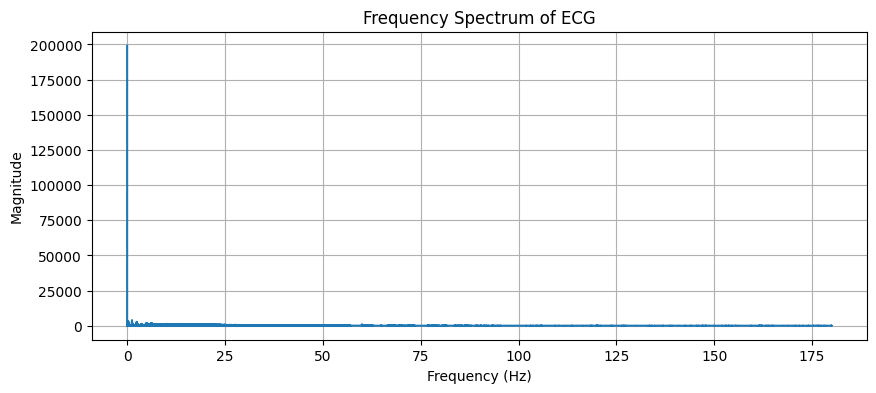

In [5]:
from scipy.fft import fft, fftfreq

N = len(ecg)
yf = fft(ecg)
xf = fftfreq(N, 1/fs)

plt.figure(figsize=(10,4))
plt.plot(xf[:N//2], np.abs(yf[:N//2]))
plt.title("Frequency Spectrum of ECG")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.show()


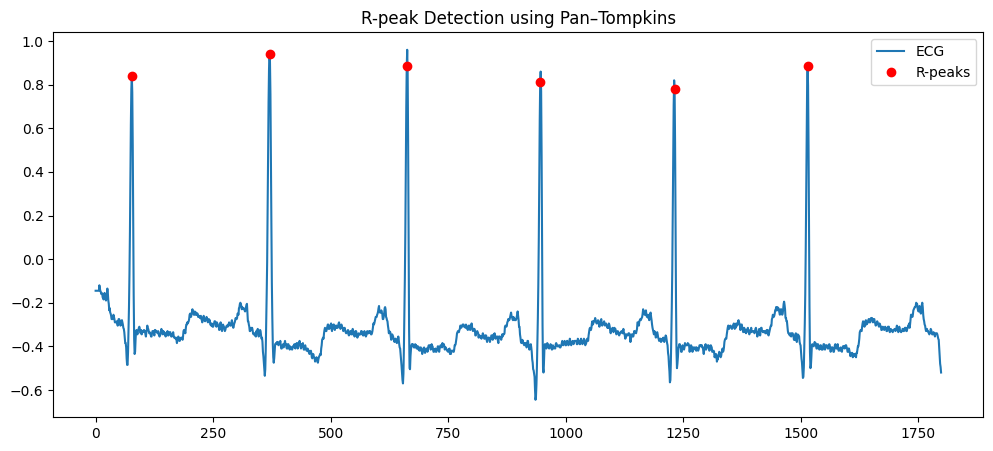

In [6]:
from scipy.signal import find_peaks

def pan_tompkins_detector(ecg, fs):

    ecg_filtered = bandpass_filter(ecg, lowcut=5, highcut=15, fs=fs)


    diff = np.diff(ecg_filtered)


    squared = diff ** 2


    window_size = int(0.15 * fs)
    mwa = np.convolve(squared, np.ones(window_size)/window_size, mode='same')


    threshold = np.mean(mwa) * 1.5
    peaks, _ = find_peaks(mwa, height=threshold, distance=int(0.2*fs))

    return peaks, mwa

peaks, mwa = pan_tompkins_detector(ecg, fs)

plt.figure(figsize=(12,5))
plt.plot(ecg[:int(5*fs)], label='ECG')
plt.plot(peaks[peaks<int(5*fs)], ecg[peaks[peaks<int(5*fs)]], 'ro', label='R-peaks')
plt.title("R-peak Detection using Pan–Tompkins")
plt.legend()
plt.show()


In [7]:
import numpy as np

def extract_ecg_features(ecg, r_peaks, fs):
    rr_intervals = np.diff(r_peaks) / fs

    -
    mean_rr = np.mean(rr_intervals)
    std_rr = np.std(rr_intervals)
    heart_rate = 60 / mean_rr  # bpm
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))  # HRV measure


    qrs_amplitudes = []
    qrs_widths = []

    window = int(0.15 * fs)  # 150 ms around each R-peak
    for peak in r_peaks:
        left = max(peak - window, 0)
        right = min(peak + window, len(ecg))
        segment = ecg[left:right]

        if len(segment) > 0:
            qrs_amplitudes.append(np.max(segment) - np.min(segment))

            half_amp = np.min(segment) + 0.5 * (np.max(segment) - np.min(segment))
            width = np.sum(segment > half_amp) / fs
            qrs_widths.append(width)


    features = {
        'mean_rr': mean_rr,
        'std_rr': std_rr,
        'heart_rate_bpm': heart_rate,
        'rmssd': rmssd,
        'mean_qrs_amp': np.mean(qrs_amplitudes),
        'mean_qrs_width': np.mean(qrs_widths)
    }

    return features


In [8]:
features = extract_ecg_features(ecg, peaks, fs)
for k, v in features.items():
    print(f"{k:20s}: {v:.4f}")


mean_rr             : 0.7946
std_rr              : 0.0490
heart_rate_bpm      : 75.5125
rmssd               : 0.0635
mean_qrs_amp        : 1.5468
mean_qrs_width      : 0.0200


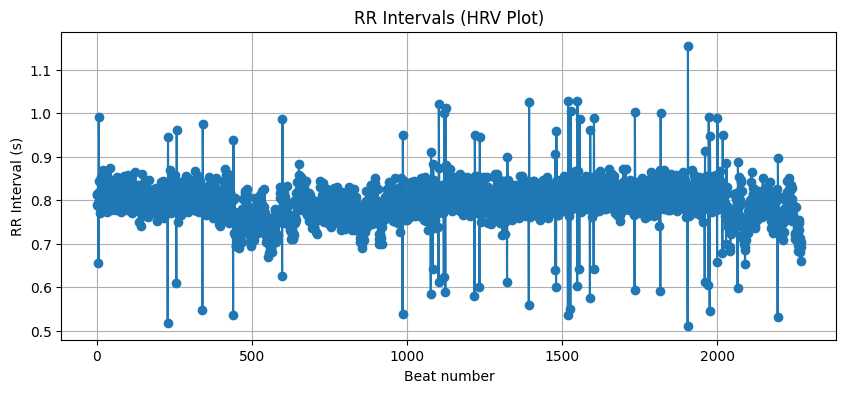

In [9]:
rr_intervals = np.diff(peaks) / fs
plt.figure(figsize=(10,4))
plt.plot(rr_intervals, marker='o')
plt.title("RR Intervals (HRV Plot)")
plt.xlabel("Beat number")
plt.ylabel("RR Interval (s)")
plt.grid()
plt.show()


Signal length: 650000 samples, Sampling rate: 360 Hz
Annotation symbols: ['+' 'A' 'N' 'V']


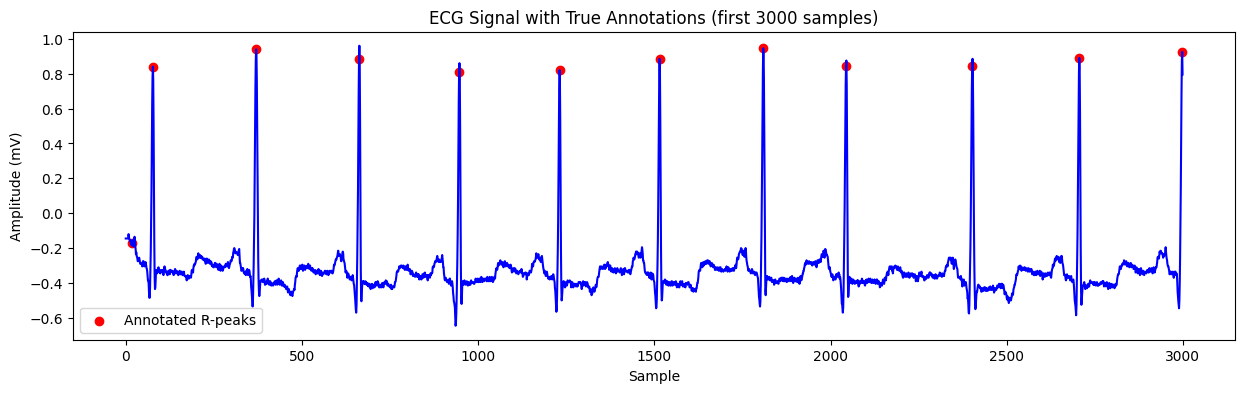

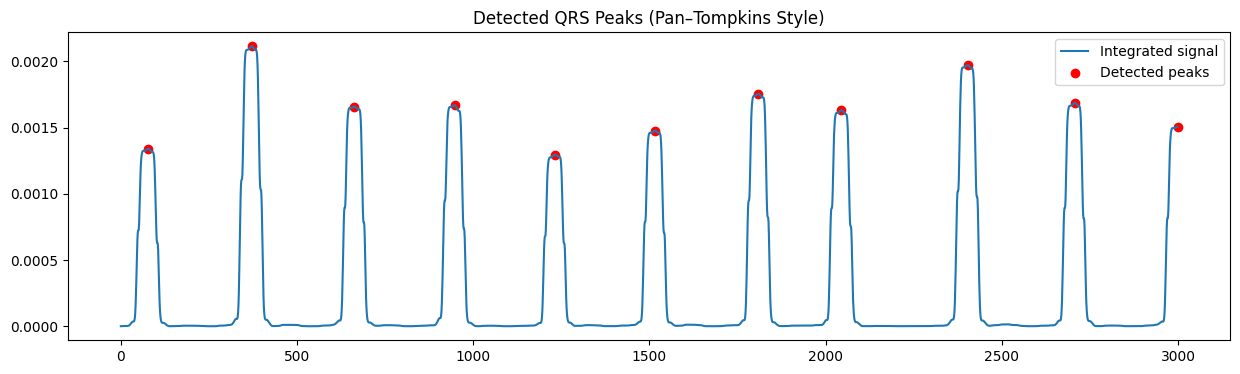

Detected R-peaks: 2273
Extracted 2272 QRS segments, each of length 72 samples


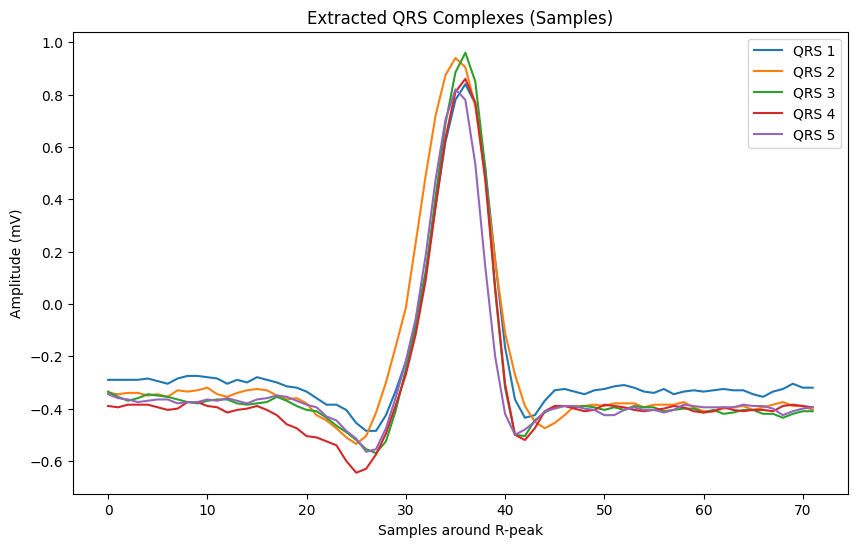

In [20]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt


record_name = '100'
# record_path = f'/content/{record_name}'  # adjust if your files are elsewhere


record = wfdb.rdrecord(record_name, pn_dir='mitdb')
annotation = wfdb.rdann(record_name, 'atr', pn_dir='mitdb')


signal = record.p_signal[:, 0]  # use first ECG channel
fs = record.fs

print(f"Signal length: {len(signal)} samples, Sampling rate: {fs} Hz")
print("Annotation symbols:", np.unique(annotation.symbol))
plt.figure(figsize=(15,4))
plt.plot(signal[0:3000], color='b')
r_peaks = annotation.sample
plt.scatter(r_peaks[r_peaks < 3000], signal[r_peaks[r_peaks < 3000]], color='r', label='Annotated R-peaks')
plt.title("ECG Signal with True Annotations (first 3000 samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.show()
from scipy.signal import find_peaks, butter, filtfilt


def bandpass_filter(sig, fs, low=5, high=15):
    b, a = butter(1, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, sig)

filtered = bandpass_filter(signal, fs)


diff_sig = np.diff(filtered)
squared = diff_sig**2
window_size = int(0.150 * fs)  # 150 ms
integrated = np.convolve(squared, np.ones(window_size)/window_size, mode='same')


peaks, _ = find_peaks(integrated, distance=int(0.2*fs), height=np.mean(integrated)*1.5)

plt.figure(figsize=(15,4))
plt.plot(integrated[0:3000], label='Integrated signal')
plt.scatter(peaks[peaks < 3000], integrated[peaks[peaks < 3000]], color='r', label='Detected peaks')
plt.legend()
plt.title("Detected QRS Peaks (Pan–Tompkins Style)")
plt.show()

print(f"Detected R-peaks: {len(peaks)}")
qrs_segments = []
window = int(0.1 * fs)  # 100 ms

for p in peaks:
    if p - window >= 0 and p + window < len(signal):
        qrs_segments.append(signal[p-window:p+window])

qrs_segments = np.array(qrs_segments)
print(f"Extracted {len(qrs_segments)} QRS segments, each of length {qrs_segments.shape[1]} samples")
plt.figure(figsize=(10,6))
for i in range(5):
    plt.plot(qrs_segments[i], label=f'QRS {i+1}')
plt.title("Extracted QRS Complexes (Samples)")
plt.xlabel("Samples around R-peak")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.show()

In [10]:
import pandas as pd

records = ['100', '101', '102']  # add more PhysioNet IDs
data = []

for rec in records:
    record = wfdb.rdrecord(rec, pn_dir='mitdb')
    ecg = record.p_signal[:,0]
    fs = record.fs
    peaks, _ = pan_tompkins_detector(ecg, fs)
    feats = extract_ecg_features(ecg, peaks, fs)
    feats['record_id'] = rec
    data.append(feats)

df = pd.DataFrame(data)
df.to_csv("ecg_features.csv", index=False)
print(df.head())


    mean_rr    std_rr  heart_rate_bpm     rmssd  mean_qrs_amp  mean_qrs_width  \
0  0.794570  0.048988       75.512506  0.063479      1.546755        0.020046   
1  0.967115  0.075260       62.040208  0.064637      1.872887        0.020751   
2  0.825625  0.035381       72.672201  0.048569      1.342917        0.049901   

  record_id  
0       100  
1       101  
2       102  


    mean_rr    std_rr  heart_rate_bpm     rmssd  mean_qrs_amp  mean_qrs_width  \
0  0.794570  0.048988       75.512506  0.063479      1.546755        0.020046   
1  0.967115  0.075260       62.040208  0.064637      1.872887        0.020751   
2  0.825625  0.035381       72.672201  0.048569      1.342917        0.049901   

   record_id  label  
0        100      0  
1        101      1  
2        102      0  
Training samples: 2
Testing samples: 1
Model: RandomForest
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

--------------------------------------------------
Model: SVM
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


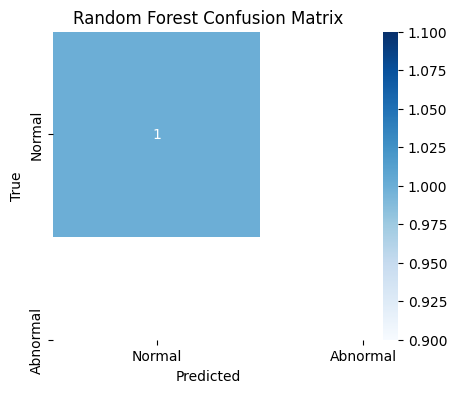

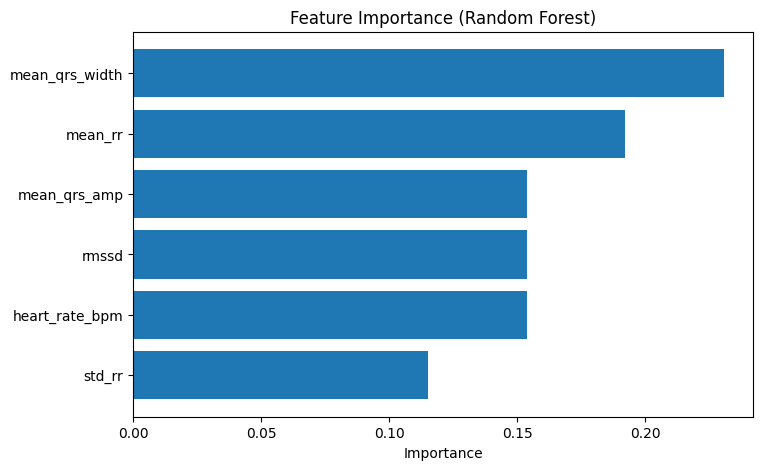

In [11]:
import pandas as pd
import numpy as np

# Load the features we created
df = pd.read_csv("ecg_features.csv")


df['label'] = [0 if i % 2 == 0 else 1 for i in range(len(df))]

print(df.head())
from sklearn.model_selection import train_test_split

X = df.drop(['record_id', 'label'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale'),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-"*50)
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_rf = models["RandomForest"].predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()
importances = models["RandomForest"].feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.barh(X.columns[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()






Shape of X: (1444, 1800)
Labels distribution: [722 722]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1796, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 898, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 898, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 896, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 448, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 448, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,570 (162.38 KB)

 Trainable params: 41,570 (162.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 297ms/step - accuracy: 0.4954 - loss: 0.6957 - val_accuracy: 0.4675 - val_loss: 0.6968
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - accuracy: 0.5014 - loss: 0.6931 - val_accuracy: 0.4978 - val_loss: 0.6938
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.4898 - loss: 0.6925 - val_accuracy: 0.4848 - val_loss: 0.6951
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.5609 - loss: 0.6901 - val_accuracy: 0.5238 - val_loss: 0.6918
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.5460 - loss: 0.6885 - val_accuracy: 0.5411 - val_loss: 0.6922
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.5663 - loss: 0.6826 - val_accuracy: 0.5238 - val_loss: 0.6971
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.5535 - loss: 0.6740 - val_accuracy: 0.7749 - val_loss: 0.5447
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step - accuracy: 0.6827 - loss: 0.6330 - val_accuracy

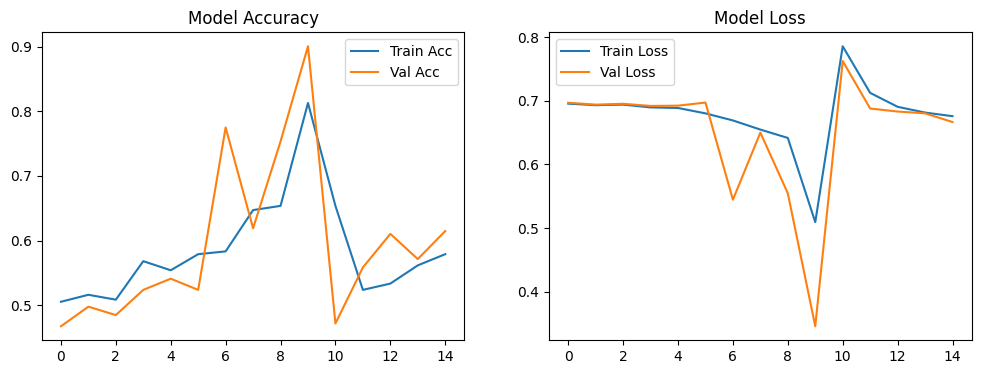

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.72      0.67       146
           1       0.66      0.57      0.61       143

    accuracy                           0.64       289
   macro avg       0.65      0.64      0.64       289
weighted avg       0.65      0.64      0.64       289



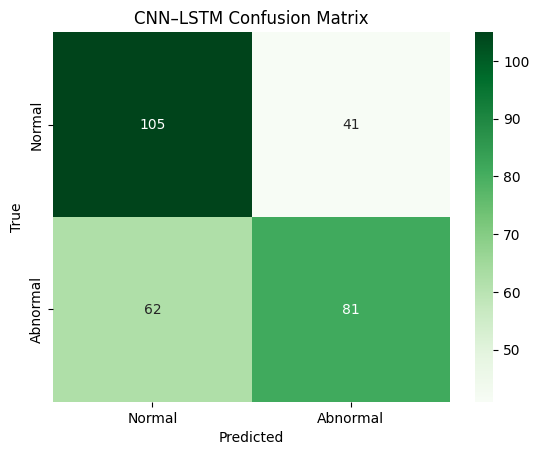

In [12]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
def load_ecg_segments(record_ids, window_sec=5, fs_target=360):
    X, y = [], []
    for rec_id in record_ids:
        record = wfdb.rdrecord(rec_id, pn_dir='mitdb')
        ecg = record.p_signal[:,0]
        fs = record.fs

        # Normalize
        ecg = (ecg - np.mean(ecg)) / np.std(ecg)

        seg_len = int(window_sec * fs)
        n_segments = len(ecg) // seg_len

        for i in range(n_segments):
            segment = ecg[i*seg_len:(i+1)*seg_len]
            X.append(segment)

            # Dummy label assignment for demo
            y.append(0 if int(rec_id) % 2 == 0 else 1)

    return np.array(X), np.array(y)

record_ids = ['100', '101', '102', '103']  # add more for richer dataset
X, y = load_ecg_segments(record_ids)

print("Shape of X:", X.shape)
print("Labels distribution:", np.bincount(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for Conv1D: (samples, timesteps, channels)
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# One-hot encode labels
y_train = to_categorical(y_train, 2)
y_test  = to_categorical(y_test, 2)
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title("CNN–LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
